In [1]:
import matplotlib.pyplot as plt
import torch
import time
import os
import timeit
import torch.utils.benchmark as benchmark
from itertools import product
import psutil

In [2]:
# Finding number of cores and threads for current env.
# Find thread range for later matrix multiplication tests.
physical_cores = psutil.cpu_count(logical=False)
logical_cores = psutil.cpu_count(logical=True)

print(f"Physical cores: {physical_cores}")
print(f"Logical processors (threads): {logical_cores}")

Physical cores: 1
Logical processors (threads): 2


In [3]:
### Naive matrix mult algo
def naive_mult(A, B):
    row_a, col_a = A.shape
    _, col_b = B.shape
    C = torch.zeros(row_a, col_b, device=A.device)

    for i in range(row_a):
        for j in range(col_b):
            for k in range(col_a):
                C[i, j] += A[i, k] * B[k, j]
    return C

### Matrix generation / tensor generation

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      # CHANGE 'device' VARIBLE FOR EACH TEST
# device = torch.device("cuda")
# device = torch.device("cpu")
print(device)
n=1000

def generate(size,size2):
    array = torch.rand((size, size2),device=device)
    return array

gpuTimer = benchmark.Timer(
    stmt="generate(n,n)",
    setup="from __main__ import generate",
    globals={'n': n},
    num_threads=1,  # Single-threaded for consistent benchmarking
)


### Using a gpu to generate data is MUCH faster!! more than 6 times faster
### generate torch array on cpu averages 6 ms
### generate torch array on gpu averages .022 - .025 ms
### all tests done for 1 matrix of size 1000x1000

cuda


In [ ]:
### for gpu benchmarking in pytorch you HAVE to use this instead of timeit because it accounts for the asynch operations in the gpu.
### Timeit will give an inaccurate reading. Usually, the time it gives is the time to enque the specified operations...
### NOT the time it takes to actually perform and return the operations.
for run in range(5): print(gpuTimer.timeit(n))

generate(n,n)
setup: from __main__ import generate
  6.65 ms
  1 measurement, 1000 runs , 1 thread
generate(n,n)
setup: from __main__ import generate
  5.61 ms
  1 measurement, 1000 runs , 1 thread
generate(n,n)
setup: from __main__ import generate
  6.78 ms
  1 measurement, 1000 runs , 1 thread
generate(n,n)
setup: from __main__ import generate
  5.63 ms
  1 measurement, 1000 runs , 1 thread
generate(n,n)
setup: from __main__ import generate
  6.74 ms
  1 measurement, 1000 runs , 1 thread


In [ ]:
# %timeit -r 3 -n 1000  generate(1000,1000)

16.6 µs ± 5.73 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


#### Large numbered array generation

In [21]:
low,high = 1000000, 1100000
n=1000

def generateLargeNumberedMat(low,high,size,size2):
    return torch.randint(low,high,(size,size2),device = device)

gpuTimer = benchmark.Timer(
    stmt="generateLargeNumberedMat(low,high,n,n)",
    setup="from __main__ import generateLargeNumberedMat",
    globals={'n': n,'low':low,'high':high},
    num_threads=1,
)

# torch.rand already runs faster than torch.randint since there is additional overhead in torch.randint
# since it has to generate the discrete integers BEFORE sampling from it. Whereas, in torch.rand, the numbers are already
# generated and the method only has to sample from a continuous sample of floats.

# 1000 runs 13-14 ms cpu 1000x1000 low 10_000 -> 100_000
# 1000 runs 13-15 ms cpu 1000x1000 low 100_000 -> 1_000_000
# 1000 runs 13-15 ms cpu 1000x1000 low 1_010_000 -> 1_100_000
# 10000 runs .040 ms gpu 1000x1000 low 10_000 -> 100_000
# 10000 runs .040 ms gpu 1000x1000 low 100_000 -> 1_000_000
# 10000 runs .040 ms gpu 1000x1000 low 1_010_000 -> 1_100_000

In [ ]:
for run in range(5): print(gpuTimer.timeit(n))

generateLargeNumberedMat(low,high,n,n)
setup: from __main__ import generateLargeNumberedMat
  13.64 ms
  1 measurement, 1000 runs , 1 thread
generateLargeNumberedMat(low,high,n,n)
setup: from __main__ import generateLargeNumberedMat
  13.65 ms
  1 measurement, 1000 runs , 1 thread
generateLargeNumberedMat(low,high,n,n)
setup: from __main__ import generateLargeNumberedMat
  13.61 ms
  1 measurement, 1000 runs , 1 thread
generateLargeNumberedMat(low,high,n,n)
setup: from __main__ import generateLargeNumberedMat
  13.69 ms
  1 measurement, 1000 runs , 1 thread
generateLargeNumberedMat(low,high,n,n)
setup: from __main__ import generateLargeNumberedMat
  14.30 ms
  1 measurement, 1000 runs , 1 thread


---

### Moving tensors

In [40]:
# moving tensor from cpu to gpu and vice versa
# you can also generate the tensor directly on the cpu or gpu which is timed in 'generate'


dev = 'cpu'           # CHANGE THIS VAR TO 'cuda'/'cpu' FOR TESTING
print("destination device",dev)
arr = generate(n,n)
print("starting device",arr.device)

def move(array,device):
    return array.to(device)

gpuTimer = benchmark.Timer(
    stmt="move(arr,dev)",
    setup="from __main__ import move",
    globals={'arr': arr, 'dev': dev},
    num_threads=1,
)

# 1000 loops for 5 runs averaged .88 ms 1000x1000 from cpu to gpu
# 1000 loops for 5 runs averaged 1 ms 1000x1000 from gpu to cpu

destination device cpu
starting device cuda:0


In [42]:
for run in range(5): print(gpuTimer.timeit(n))

move(arr,dev)
setup: from __main__ import move
  1.04 ms
  1 measurement, 1024 runs , 1 thread
move(arr,dev)
setup: from __main__ import move
  938.74 us
  1 measurement, 1024 runs , 1 thread
move(arr,dev)
setup: from __main__ import move
  937.39 us
  1 measurement, 1024 runs , 1 thread
move(arr,dev)
setup: from __main__ import move
  943.36 us
  1 measurement, 1024 runs , 1 thread
move(arr,dev)
setup: from __main__ import move
  1.79 ms
  1 measurement, 1024 runs , 1 thread


---

### Matrix multiplication

In [8]:
mat1 = generate(1000,1000)
mat2 = generate(1000,1000)
# mat1 = generateLargeNumberedMat(low,high,n,n)
# mat2 = generateLargeNumberedMat(low,high,n,n)

In [9]:
def mult(A,B): #utilizes broadcasting
    resultMat = (A[:, :, None] * B[None, :, :]).sum(dim=1)
    return resultMat

gpuTimer = benchmark.Timer(
    stmt="mult(mat1,mat2)",
    setup="from __main__ import mult",
    globals={'mat1': mat1,
             'mat2':mat2},
    num_threads=1,
)
  # torch gpu at 1000x1000 matrix with 1000 loops --> 49 ms
  # torch cpu at 1000x1000 matrix with 100 loops --> 3.1 sec  (mult)
  # torch cpu at 1000x1000 matrix with 100 loops large numbers --> 8.1 sec
  # torch gpu at 1000x1000 matrix with 100 loops large numbers --> 49.5 ms

In [ ]:
assert torch.allclose(torch.matmul(mat1,mat2), mult(mat1,mat2))

In [ ]:
for run in range(5): print(gpuTimer.timeit(100))

mult(mat1,mat2)
setup: from __main__ import mult
  49.55 ms
  1 measurement, 1000 runs , 1 thread
mult(mat1,mat2)
setup: from __main__ import mult
  49.56 ms
  1 measurement, 1000 runs , 1 thread
mult(mat1,mat2)
setup: from __main__ import mult
  49.55 ms
  1 measurement, 1000 runs , 1 thread
mult(mat1,mat2)
setup: from __main__ import mult
  49.56 ms
  1 measurement, 1000 runs , 1 thread
mult(mat1,mat2)
setup: from __main__ import mult
  49.56 ms
  1 measurement, 1000 runs , 1 thread


In [22]:
# Comparing a list of increasing matrix sizes and comparing
# Includes both square and non-square matrices
results = []

sizes = [1,64,256,1024]
for b, n in product(sizes, sizes): # Loop over matrix sizes
    label = 'mat mult'
    sub_label = f'[{b}, {n}]'

    # Generate tensors                                  # UNCOMMENT/COMMENT OUT ONE PAIR OF X/Y GENERATION STMTS FOR LARGE-NUM MATRIX TEST VS OG TEST
    # x = torch.rand((b,n),device='cuda')
    # y = x.to('cpu')
    x = torch.randint(low,high,(b,n),device='cuda')
    y = x.to('cpu')

    # GPU
    results.append(benchmark.Timer(
        stmt='mult(x, x.T)',
        setup='from __main__ import mult',
        globals={'x': x},
        label=label,
        sub_label=sub_label,
        description='gpu',
    ).blocked_autorange(min_run_time=1))
    # Multi-threaded Broadcast CPU
    results.append(benchmark.Timer(
        stmt='mult(y, y.T)',
        setup='from __main__ import mult',
        globals={'y': y},
        label=label,
        sub_label=sub_label,
        num_threads=2,
        description='cpu multi-threaded',
    ).blocked_autorange(min_run_time=1))
    # Single-threaded Broadcast CPU
    results.append(benchmark.Timer(
        stmt='mult(y, y.T)',
        setup='from __main__ import mult',
        globals={'y': y},
        label=label,
        sub_label=sub_label,
        num_threads=1,
        description='cpu single-threaded',
    ).blocked_autorange(min_run_time=1))
    # Naive Single Threaded
    if(b*n <= 64*64): # Have to perform this check since it runs WAY too slow on larger arrays
      results.append(benchmark.Timer(
        stmt='naive_mult(y, y.T)',
        setup='from __main__ import naive_mult',
        globals={'y': y},
        label=label,
        sub_label=sub_label,
        num_threads=1,
        description='cpu naive',
      ).blocked_autorange(min_run_time=1))

compare = benchmark.Compare(results)
compare.print()

[----------------------------------------- mat mult ----------------------------------------]
                    |    gpu     |  cpu multi-threaded  |  cpu single-threaded  |  cpu naive 
1 threads: ----------------------------------------------------------------------------------
      [1, 1]        |      35.0  |                      |            19.1       |        30.4
      [1, 64]       |      50.4  |                      |            19.5       |      1402.7
      [1, 256]      |      35.1  |                      |            19.7       |      5753.5
      [1, 1024]     |      36.0  |                      |            20.5       |     22157.5
      [64, 1]       |      35.9  |                      |            29.2       |     92158.9
      [64, 64]      |      37.0  |                      |           418.5       |   6667279.6
      [64, 256]     |      78.2  |                      |          1562.5       |            
      [64, 1024]    |     271.9  |                      |   

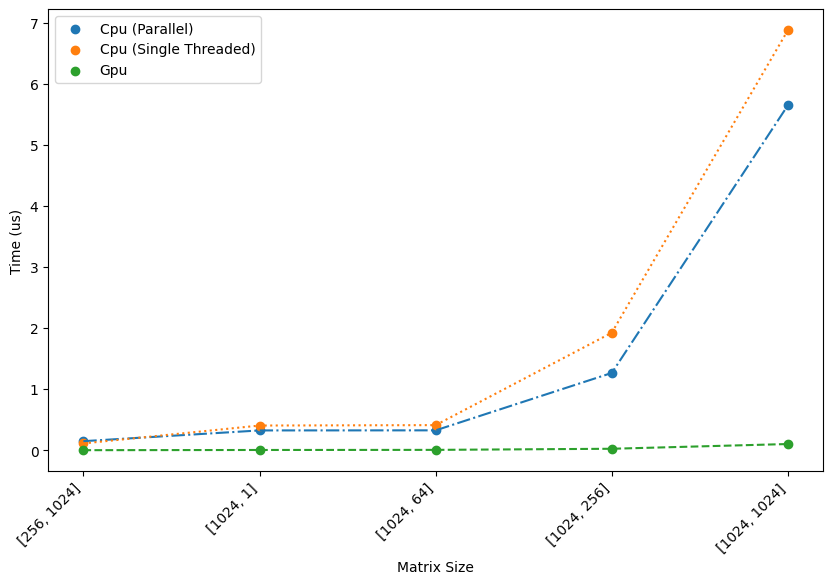

In [23]:
# Generate trend-line plot to show efficiency differences between cpu and gpu methods

gpupts = []
cpuparallelpts = []
cpusinglepts = []
naivepts = []

x = list(product(sizes,sizes))
x_labels = [f"[{n[0]}, {n[1]}]" for n in x]
x_indices = list(range(len(x[11:])))

j = 0
for r in results:
  if(r.description == 'gpu'):
    gpupts.append((r.description,x[j],r.mean))
  elif(r.description == 'cpu multi-threaded'):
    cpuparallelpts.append((r.description,x[j],r.mean))
  elif(r.description == 'cpu single-threaded'):
    cpusinglepts.append((r.description,x[j],r.mean))
    j+=1

gpupts = sorted(gpupts, key=lambda x: x[1][0]*x[1][1])[11:]
cpuparallelpts = sorted(cpuparallelpts, key=lambda x: x[1][0]*x[1][1])[11:]
cpusinglepts = sorted(cpusinglepts, key=lambda x: x[1][0]*x[1][1])[11:]
x = x[11:]
x_labels = x_labels[11:]

plt.figure(figsize=(10, 6))

plt.scatter(list(range(len(x))),[x[2] for x in cpuparallelpts],label="Cpu (Parallel)")
plt.plot(list(range(len(x))),[x[2] for x in cpuparallelpts],linestyle='dashdot',)
plt.scatter(list(range(len(x))),[x[2] for x in cpusinglepts],label="Cpu (Single Threaded)")
plt.plot(list(range(len(x))),[x[2] for x in cpusinglepts],linestyle='dotted',)
plt.scatter(list(range(len(x))),[x[2] for x in gpupts],label="Gpu")
plt.plot(list(range(len(x))),[x[2] for x in gpupts],linestyle='dashed',)

plt.xlabel("Matrix Size")
plt.ylabel("Time (us)")
plt.legend()
plt.xticks(ticks=x_indices, labels=x_labels, rotation=45, ha='right')
plt.show()

---

### Batch Matrix Multiplication

In [43]:
def batch_generate(batch_size, size,size2,device):
    array = torch.rand(batch_size,size, size2, device=device)
    return array

In [44]:
### Batch naive matrix multiplication
def batch_naive_mult(A, B):
    batch_size, row_a, col_a = A.shape
    _, _, col_b = B.shape

    C = torch.zeros(batch_size, row_a, col_b, device=A.device)
    # loop through each batch
    for b in range(batch_size):
      for i in range(row_a):
          for j in range(col_b):
              for k in range(col_a):
                    C[b, i, j] += A[b, i, k] * B[b, k, j]
    return C

In [45]:
### batch parallelized mult
def broadcastBatchMult(A, B):
    resultMat = (A[:, :, :, None] * B[:, None, :, :]).sum(dim=2)
    return resultMat

In [46]:
### function for n-threaded matrix multiplication
def threaded_matmul(A,B,num_threads):
    torch.set_num_threads(num_threads)
    C = batch_naive_mult(A, B)
    return C

In [47]:
array = batch_generate(10,32,32,'cpu')
array2 = batch_generate(10,32,32,'cpu')
assert torch.allclose(torch.bmm(array, array2), broadcastBatchMult(array,array2))
assert torch.allclose(torch.bmm(array, array2), threaded_matmul(array,array2,2))

In [48]:
batch_sizes = [1, 10, 50, 100, 500]
matrix_size = 64
num_threads_list = [1,2]
results = []
for batch_size in batch_sizes: # Loop over batch sizes
    label = 'batch mat mult'
    sub_label = f'[{batch_size}]'
    # Generate tensors
    cpu_array = batch_generate(batch_size, matrix_size, matrix_size,'cpu')
    gpu_array = cpu_array.to('cuda')

    for thread_num in num_threads_list: # Loop over thread count
      # GPU
      results.append(benchmark.Timer(
          stmt='broadcastBatchMult(gpu_array, gpu_array)',
          setup='from __main__ import broadcastBatchMult',
          globals={'gpu_array': gpu_array},
          label=label,
          sub_label=sub_label,
          description='gpu batch',
          num_threads=thread_num
      ).blocked_autorange(min_run_time=1))
      # Broadcast CPU
      results.append(benchmark.Timer(
          stmt='broadcastBatchMult(cpu_array, cpu_array)',
          setup='from __main__ import broadcastBatchMult',
          globals={'cpu_array': cpu_array},
          label=label,
          sub_label=sub_label,
          description='cpu broadcast batch',
          num_threads=thread_num
      ).blocked_autorange(min_run_time=1))
      # Naive CPU
      if(batch_size <= 10):
        results.append(benchmark.Timer(
            stmt='threaded_matmul(cpu_array, cpu_array,thread_num)',
            setup='from __main__ import threaded_matmul',
            globals={'cpu_array': cpu_array,'thread_num':thread_num},
            label=label,
            sub_label=sub_label,
            description='cpu naive batch',
            num_threads=thread_num
        ).blocked_autorange(min_run_time=1))

compare = benchmark.Compare(results)
compare.print()

[-------------------------- batch mat mult -------------------------]
             |  gpu batch  |  cpu broadcast batch  |  cpu naive batch
1 threads: ----------------------------------------------------------
      [1]    |      37.7   |           155.5       |      7781998.1  
      [10]   |      98.6   |          1200.3       |     70546798.4  
      [50]   |     450.7   |         32330.0       |                 
      [100]  |     906.9   |         73129.6       |                 
      [500]  |    4461.7   |        354997.7       |                 
2 threads: ----------------------------------------------------------
      [1]    |      37.7   |           120.2       |      7298588.8  
      [10]   |      98.7   |          1040.4       |     70486696.6  
      [50]   |     460.0   |         25708.0       |                 
      [100]  |     909.1   |         62039.2       |                 
      [500]  |    4506.5   |        282526.4       |                 

Times are in micros